In [1]:
from statsmodels.regression.rolling import RollingOLS # estimates relationship b/w dep & indep var using min square diff over a rolling window
import pandas_datareader.data as web # takes web info and stores as dataframe
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np # calculations
import datetime as dt
import yfinance as yf # stock data
import statsmodels.api as sm # stat models
import pandas_ta # technical indicators calculator
import warnings

warnings.filterwarnings('ignore') # annoying :(

# collect sp500 stock data over the past decade, leaving a time gap for testing
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-02-01'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*10)

df = yf.download(tickers=symbols_list, start=start_date, end=end_date)
df = df.stack() # multi indexed

df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

# calculate technical indicators
# Garman-Klass Volatility, RSI, Bollinger Bands, ATR, MACD, Dollar Volume

df['garman-klass_vol'] = (0.5 * (np.log(df['high'] / df['low'])**2)) - (2 * np.log(2) - 1) * (np.log(df['adj close'] / df['open'])**2)
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x : pandas_ta.rsi(close=x, length=20))
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x : pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x : pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x : pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'], low=stock_data['low'], close=stock_data['close'], length=14)
    return atr.sub(atr.mean()).div(atr.std()) # normalize it

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std()) # normalize it

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)
df['dollar_vol'] = (df['adj close']*df['volume'])/1e6 # divide by a million

# aggregate to a monthly level and filter top 150 liquid stocks

[*********************100%%**********************]  503 of 503 completed

3 Failed downloads:
['GEV', 'SW', 'SOLV']: YFChartError("%ticker%: Data doesn't exist for startDate = 1391403600, endDate = 1706763600")


In [2]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_vol', 'volume', 'open', 'high', 'low', 'close']]
data = (pd.concat([df.unstack('ticker')['dollar_vol'].resample('M').mean().stack('ticker').to_frame('dollar_vol'),
    df.unstack()[last_cols].resample('M').last().stack('ticker')], axis=1)).dropna()

data

dollar_vol   adj close       atr   bb_high    bb_low  \
date       ticker                                                          
2014-03-31 A        126.319506   36.615662 -0.857146  3.678265  3.594556   
           AAL      325.555884   34.504333  0.296276  3.637816  3.534184   
           AAPL    3992.431361   16.861734 -1.043426  2.893677  2.860098   
           ABBV     196.676016   33.445557 -1.171081  3.577047  3.520859   
           ABT      271.044235   31.452074 -0.971604  3.525575  3.466211   
...                        ...         ...       ...       ...       ...   
2024-01-31 ABNB     607.570974  144.139999 -0.809756  5.023789  4.879181   
           CEG      178.015809  121.574860  0.243683  4.819868  4.705704   
           GEHC     195.719213   73.306999 -0.657909  4.368420  4.284151   
           KVUE     337.750732   20.332668 -1.637289  3.114890  3.036682   
           VLTO     106.635028   76.542038 -0.863830  4.384079  4.324689   

                     bb_mid  garman-klass_vol      macd        rsi  
date       ticker                                                   
2014-03-31 A       3.636410         -0.001604 -0.402019  47.426558  
           AAL     3.586000         -0.000081  0.258450  51.337297  
           AAPL    2.876887         -0.006781 -0.216542  57.630532  
           ABBV    3.548953         -0.070839 -0.083475  52.861516  
           ABT     3.495893         -0.015633 -0.194080  50.126724  
...                     ...               ...       ...        ...  
2024-01-31 ABNB    4.951485          0.000177  0.627040  55.591518  
           CEG     4.762786          0.000225  0.130420  58.680220  
           GEHC    4.326285          0.000185 -0.464739  48.485821  
           KVUE    3.075786         -0.000285  0.493494  48.524633  
           VLTO    4.354384          0.000123 -0.520899  48.633597  

[57979 rows x 9 columns]

In [3]:
data['dollar_vol'] = data['dollar_vol'].unstack('ticker').rolling(window=5*12, min_periods=1).mean().stack()
data['dollar_vol_rank'] = data.groupby('date')['dollar_vol'].rank(ascending=False)

data = data[data['dollar_vol_rank'] < 150].drop(['dollar_vol', 'dollar_vol_rank'], axis=1)


In [4]:
def calculate_returns(df):
    outlier_cutoff = 0.005 # 99.5 percentile
    lags = [1, 2, 3, 6, 9, 12]
    
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                               .pct_change(lag)
                               .pipe(lambda x : x.clip(lower=x.quantile(outlier_cutoff),
                                                        upper=x.quantile(1-outlier_cutoff)))
                               .add(1)
                               .pow(1/lag)
                               .sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2015-03-31 AAL      50.110542  1.039930  4.012115  3.795229  3.903672   
           AAPL     27.882063 -0.793663  3.399814  3.345213  3.372514   
           ABBV     39.305683 -0.801353  3.748955  3.637127  3.693041   
           ABT      38.674706 -0.932665  3.712882  3.674980  3.693931   
           ACN      79.747543 -0.791334  4.405808  4.309094  4.357451   
...                       ...       ...       ...       ...       ...   
2024-01-31 PYPL     61.349998 -0.288796  4.200090  4.073021  4.136555   
           MRNA    101.050003 -0.484077  4.743255  4.575398  4.659326   
           UBER     65.269997 -0.232307  4.251146  4.067695  4.159421   
           CRWD    292.500000  0.357575  5.773605  5.510642  5.642123   
           ABNB    144.139999 -0.809756  5.023789  4.879181  4.951485   

                   garman-klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2015-03-31 AAL            -0.001614  1.173725  54.797234   0.101879   
           AAPL           -0.005673 -0.250246  50.588890  -0.031371   
           ABBV           -0.058350 -0.360851  47.251194  -0.032397   
           ABT            -0.014045 -0.128544  48.603210  -0.021955   
           ACN            -0.010408  0.035778  58.787006   0.040653   
...                             ...       ...        ...        ...   
2024-01-31 PYPL            0.000357  0.151459  50.483795  -0.000977   
           MRNA            0.000541  0.163110  53.685085   0.016089   
           UBER            0.000213  1.201673  61.076894   0.060094   
           CRWD            0.000353  1.834932  64.365543   0.145621   
           ABNB            0.000177  0.627040  55.591518   0.058763   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2015-03-31 AAL      0.038059  -0.004640   0.069241   0.023940    0.031584  
           AAPL     0.032591   0.042114   0.037238   0.034484    0.042802  
           ABBV    -0.015110  -0.034055   0.004732   0.006577    0.013545  
           ABT      0.017387   0.011385   0.019948   0.015743    0.017376  
           ACN      0.055916   0.016087   0.026184   0.018050    0.015697  
...                      ...        ...        ...        ...         ...  
2024-01-31 PYPL     0.031949   0.058023  -0.034679  -0.023512   -0.023379  
           MRNA     0.140401   0.099809  -0.025045  -0.029976   -0.045213  
           UBER     0.075955   0.146768   0.047313   0.083924    0.064211  
           CRWD     0.110959   0.182785   0.103877   0.104012    0.088351  
           ABNB     0.068124   0.068101  -0.009017   0.020887    0.021926  

[15329 rows x 14 columns]

In [5]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                             'famafrench',
                             start='2015')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data.xs('AAPL', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2015-03-31,-0.0112,0.0307,-0.0037,0.0009,-0.0052,-0.031371
2015-04-30,0.0059,-0.0309,0.0182,0.0006,-0.0061,0.005786
2015-05-31,0.0136,0.0083,-0.0114,-0.0179,-0.0074,0.045339
2015-06-30,-0.0153,0.0290,-0.0079,0.0044,-0.0158,-0.037228
2015-07-31,0.0154,-0.0455,-0.0413,0.0030,-0.0241,-0.032927


In [6]:
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2015-03-31 AAL    -0.0112  0.0307 -0.0037  0.0009 -0.0052   0.101879
           AAPL   -0.0112  0.0307 -0.0037  0.0009 -0.0052  -0.031371
           ABBV   -0.0112  0.0307 -0.0037  0.0009 -0.0052  -0.032397
           ABT    -0.0112  0.0307 -0.0037  0.0009 -0.0052  -0.021955
           ACN    -0.0112  0.0307 -0.0037  0.0009 -0.0052   0.040653
...                   ...     ...     ...     ...     ...        ...
2024-01-31 VRTX    0.0070 -0.0574 -0.0233  0.0069 -0.0099   0.065104
           VZ      0.0070 -0.0574 -0.0233  0.0069 -0.0099   0.122097
           WFC     0.0070 -0.0574 -0.0233  0.0069 -0.0099   0.019504
           WMT     0.0070 -0.0574 -0.0233  0.0069 -0.0099   0.048208
           XOM     0.0070 -0.0574 -0.0233  0.0069 -0.0099   0.028306

[15307 rows x 6 columns]

In [7]:
betas = factor_data.groupby(level=1,
                            group_keys=False).apply(lambda x : RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
               .fit(params_only=True)
               .params.drop('const', axis=1))

data = data.join(betas.groupby('ticker').shift())

In [8]:
factors = ['Mkt-RF', 'SMB',	'HML', 'RMW', 'CMA']
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x : x.fillna(x.mean()))

data = data.dropna()
data = data.drop('adj close', axis = 1)

data.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15161 entries, (Timestamp('2015-03-31 00:00:00'), 'AAL') to (Timestamp('2024-01-31 00:00:00'), 'ABNB')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               15161 non-null  float64
 1   bb_high           15161 non-null  float64
 2   bb_low            15161 non-null  float64
 3   bb_mid            15161 non-null  float64
 4   garman-klass_vol  15161 non-null  float64
 5   macd              15161 non-null  float64
 6   rsi               15161 non-null  float64
 7   return_1m         15161 non-null  float64
 8   return_2m         15161 non-null  float64
 9   return_3m         15161 non-null  float64
 10  return_6m         15161 non-null  float64
 11  return_9m         15161 non-null  float64
 12  return_12m        15161 non-null  float64
 13  Mkt-RF            15161 non-null  float64
 14  SMB               15161 non-null  float64
 15  HML       

In [10]:
from sklearn.cluster import KMeans

#data = data.drop('cluster', axis=1)

target_rsi_vals = [30, 45, 55, 70]
initial_centroids = np.zeros((len(target_rsi_vals), 18)) # centers and num features
initial_centroids[:, 6] = target_rsi_vals

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                          random_state=0, # random seed
                          init=initial_centroids).fit(df).labels_ # clusters created based on pre-defined centers
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman-klass_vol  \
date       ticker                                                             
2015-03-31 AAL     1.039930  4.012115  3.795229  3.903672         -0.001614   
           AAPL   -0.793663  3.399814  3.345213  3.372514         -0.005673   
           ABBV   -0.801353  3.748955  3.637127  3.693041         -0.058350   
           ABT    -0.932665  3.712882  3.674980  3.693931         -0.014045   
           ACN    -0.791334  4.405808  4.309094  4.357451         -0.010408   
...                     ...       ...       ...       ...               ...   
2024-01-31 PYPL   -0.288796  4.200090  4.073021  4.136555          0.000357   
           MRNA   -0.484077  4.743255  4.575398  4.659326          0.000541   
           UBER   -0.232307  4.251146  4.067695  4.159421          0.000213   
           CRWD    0.357575  5.773605  5.510642  5.642123          0.000353   
           ABNB   -0.809756  5.023789  4.879181  4.951485          0.000177   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2015-03-31 AAL     1.173725  54.797234   0.101879   0.038059  -0.004640   
           AAPL   -0.250246  50.588890  -0.031371   0.032591   0.042114   
           ABBV   -0.360851  47.251194  -0.032397  -0.015110  -0.034055   
           ABT    -0.128544  48.603210  -0.021955   0.017387   0.011385   
           ACN     0.035778  58.787006   0.040653   0.055916   0.016087   
...                     ...        ...        ...        ...        ...   
2024-01-31 PYPL    0.151459  50.483795  -0.000977   0.031949   0.058023   
           MRNA    0.163110  53.685085   0.016089   0.140401   0.099809   
           UBER    1.201673  61.076894   0.060094   0.075955   0.146768   
           CRWD    1.834932  64.365543   0.145621   0.110959   0.182785   
           ABNB    0.627040  55.591518   0.058763   0.068124   0.068101   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2015-03-31 AAL      0.069241   0.023940    0.031584  1.333642  0.950703   
           AAPL     0.037238   0.034484    0.042802  1.091026 -0.168418   
           ABBV     0.004732   0.006577    0.013545  0.796455  0.292490   
           ABT      0.019948   0.015743    0.017376  1.019217 -0.137675   
           ACN      0.026184   0.018050    0.015697  1.154136 -0.211658   
...                      ...        ...         ...       ...       ...   
2024-01-31 PYPL    -0.034679  -0.023512   -0.023379  1.556766 -0.511498   
           MRNA    -0.025045  -0.029976   -0.045213  1.628050  1.991030   
           UBER     0.047313   0.083924    0.064211  1.267394  0.150058   
           CRWD     0.103877   0.104012    0.088351  0.567564 -1.243742   
           ABNB    -0.009017   0.020887    0.021926  1.453808  0.617665   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2015-03-31 AAL     0.713727  1.012056  0.062160        2  
           AAPL   -0.402734  0.644906 -0.701253        2  
           ABBV   -0.009735 -0.203250  0.030620        1  
           ABT    -0.600975  0.113481  0.620754        1  
           ACN    -0.199544  0.114559 -0.057047        3  
...                     ...       ...       ...      ...  
2024-01-31 PYPL    0.513657 -1.318216 -0.713408        1  
           MRNA   -1.649489  1.434725  1.946588        2  
           UBER   -0.030753 -1.888352 -0.978477        2  
           CRWD   -0.159238 -3.139579 -1.343313        3  
           ABNB   -0.059373 -1.007095 -0.258818        2  

[15161 rows x 19 columns]

In [11]:
def plot_clusters(df):
    cluster0 = df[df['cluster']==0]
    cluster1 = df[df['cluster']==1]
    cluster2 = df[df['cluster']==2]
    cluster3 = df[df['cluster']==3]

    plt.scatter(cluster0.iloc[:,0], cluster0.iloc[:,6], color='red', label='cluster 0')
    plt.scatter(cluster1.iloc[:,0], cluster1.iloc[:,6], color='green', label='cluster 1')
    plt.scatter(cluster2.iloc[:,0], cluster2.iloc[:,6], color='blue', label='cluster 2')
    plt.scatter(cluster3.iloc[:,0], cluster3.iloc[:,6], color='yellow', label='cluster 3')

    plt.legend()
    plt.show()
    return

plt.style.use('ggplot')

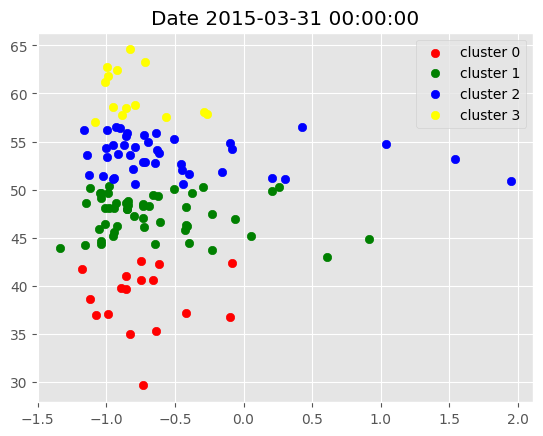

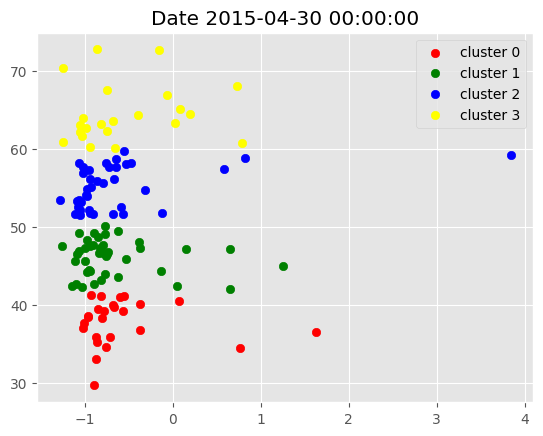

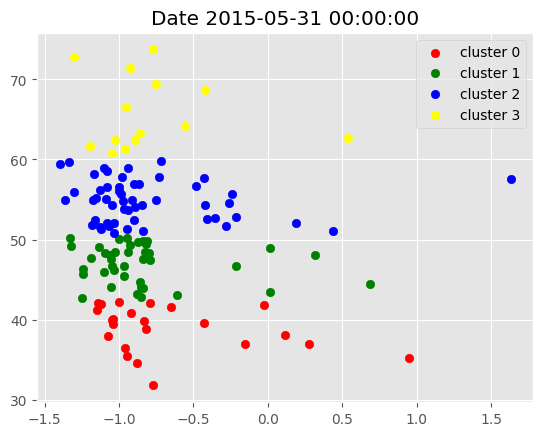

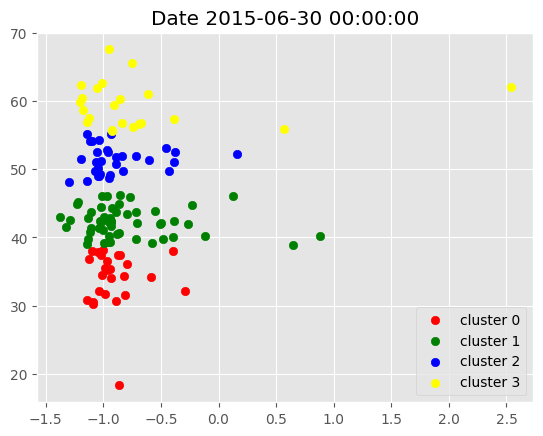

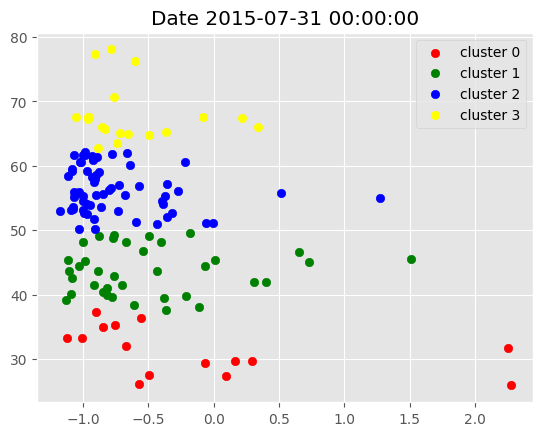

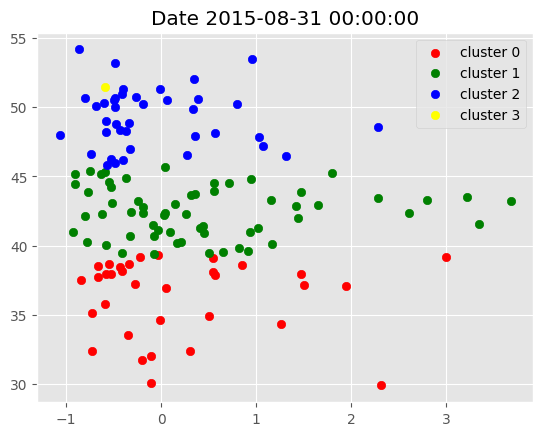

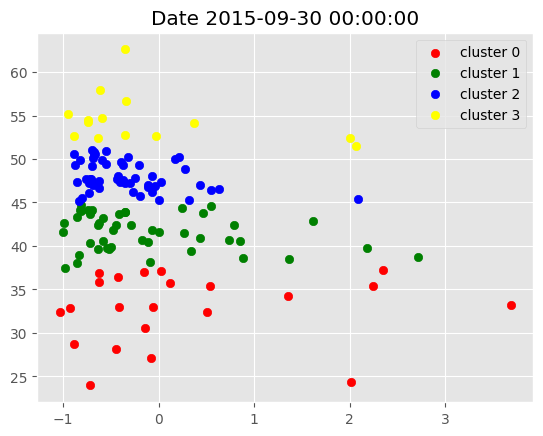

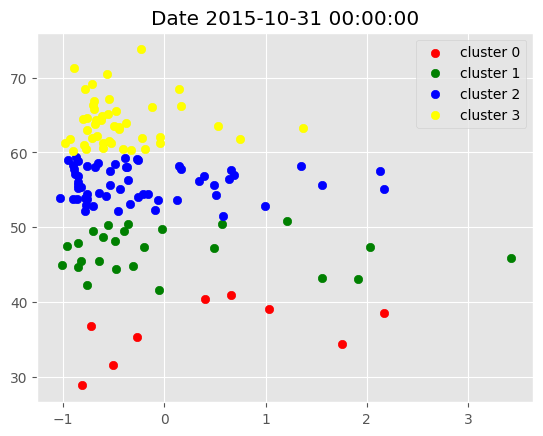

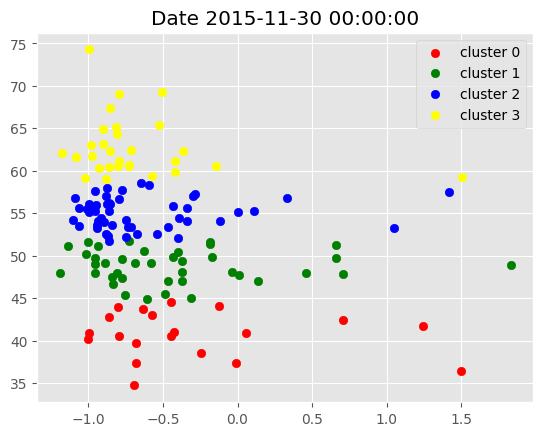

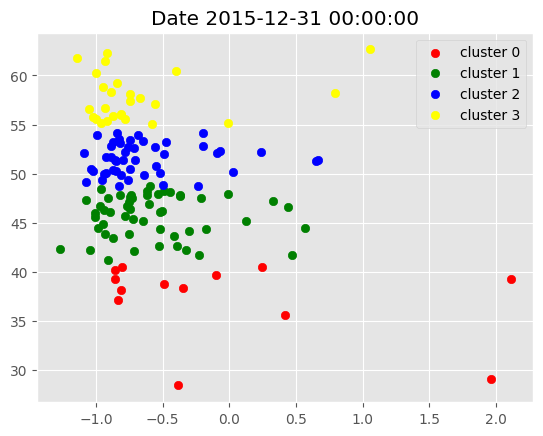

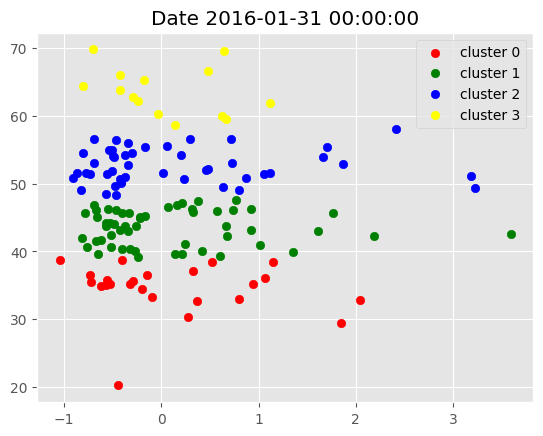

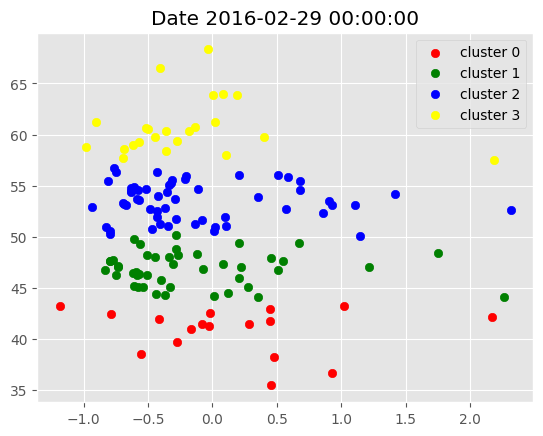

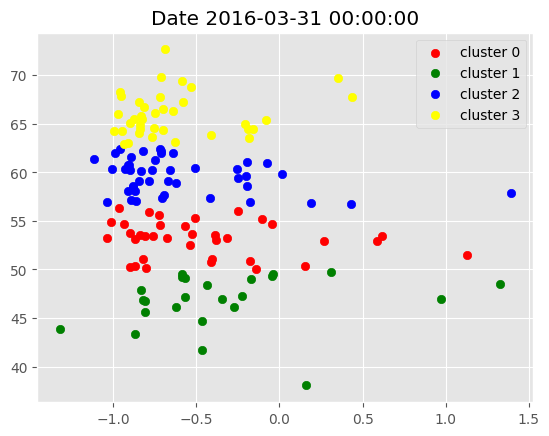

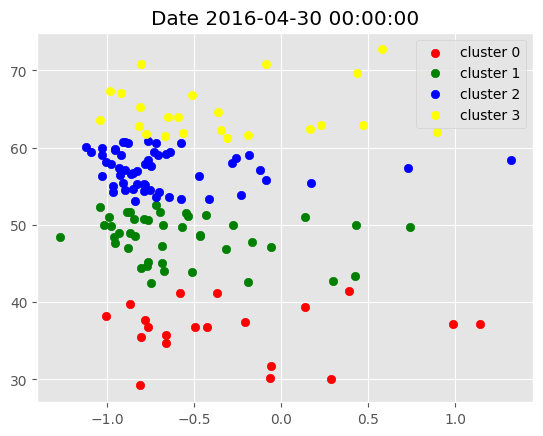

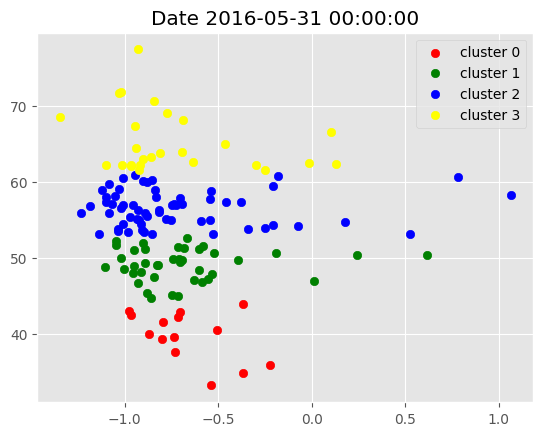

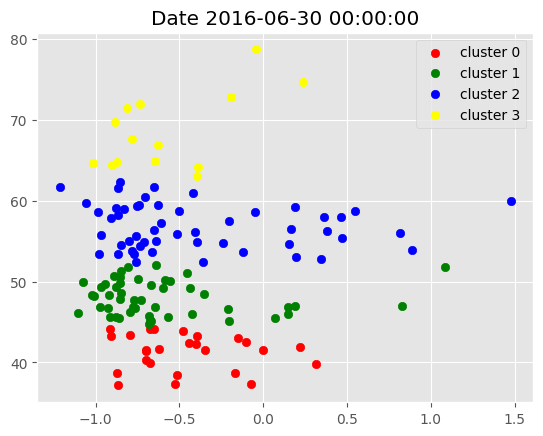

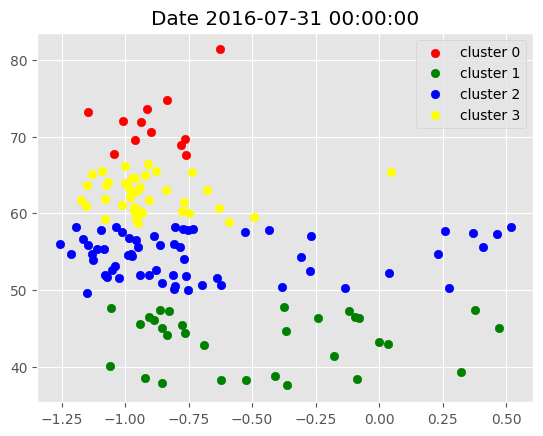

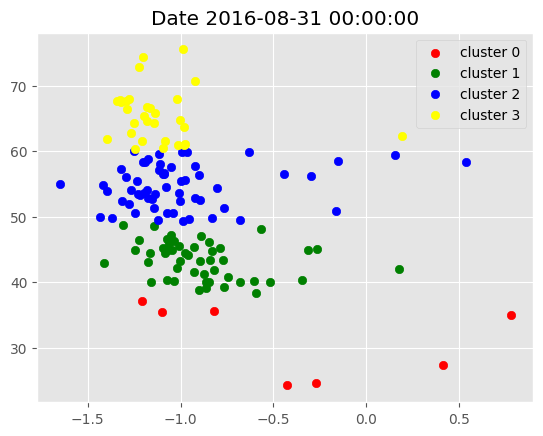

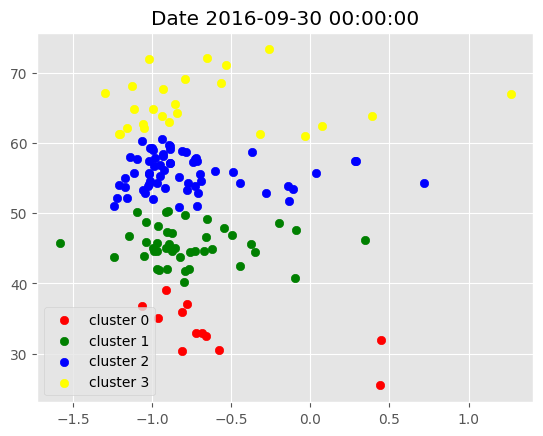

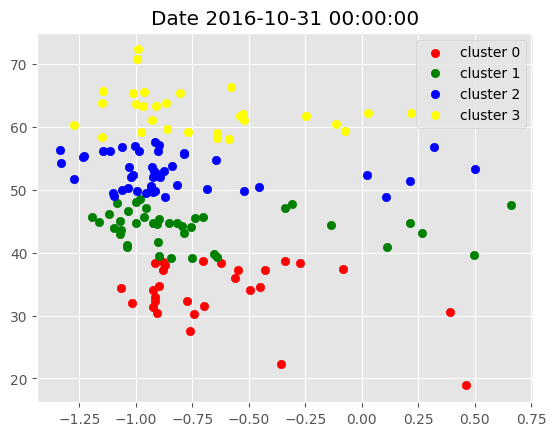

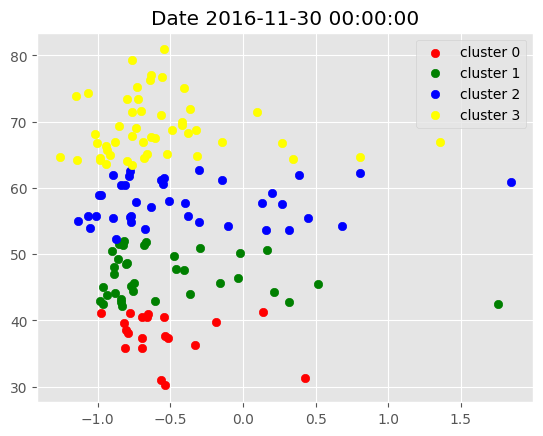

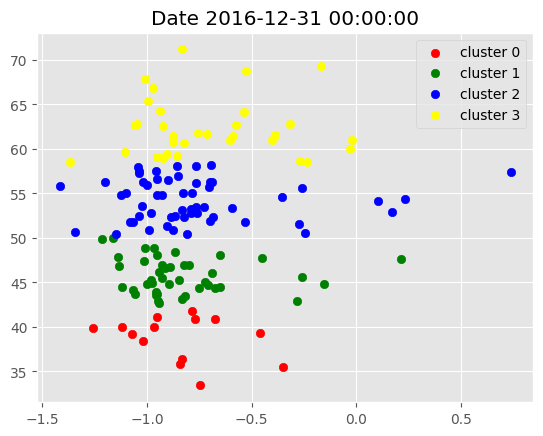

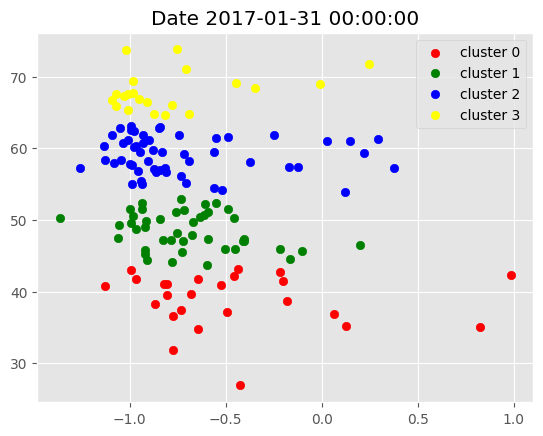

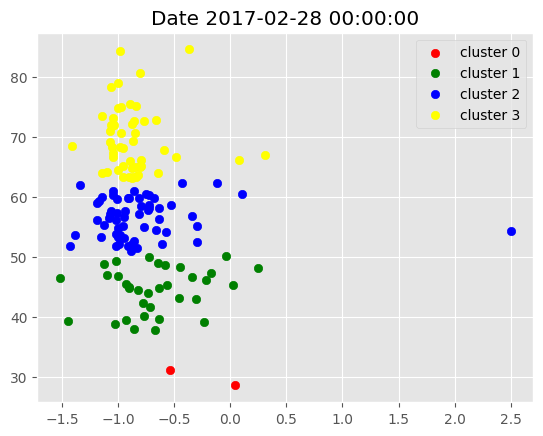

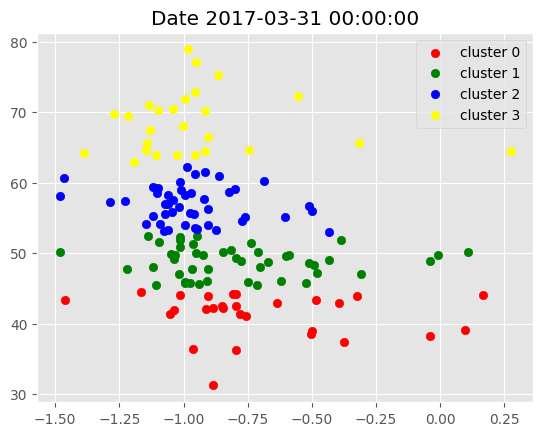

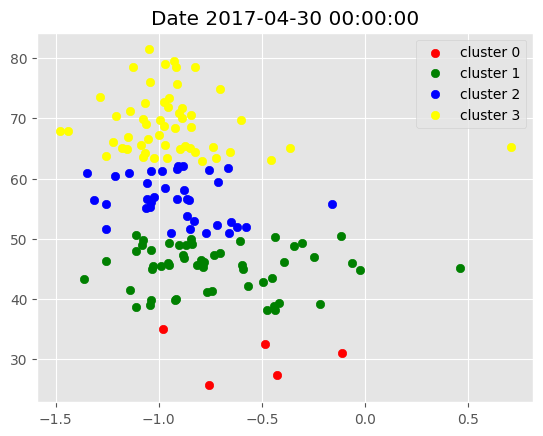

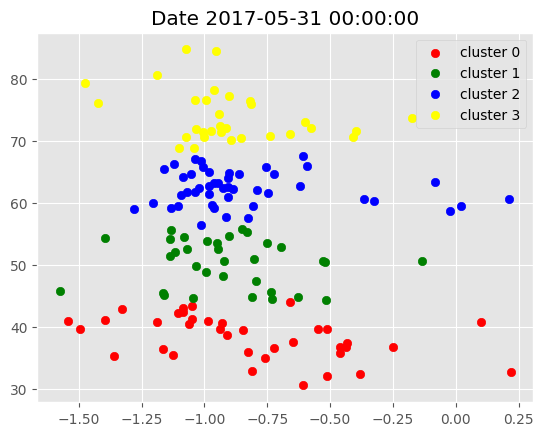

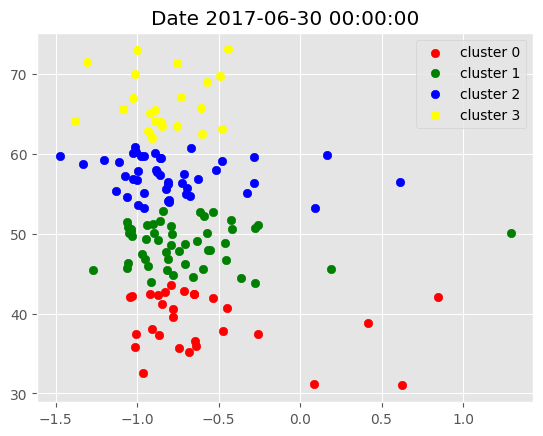

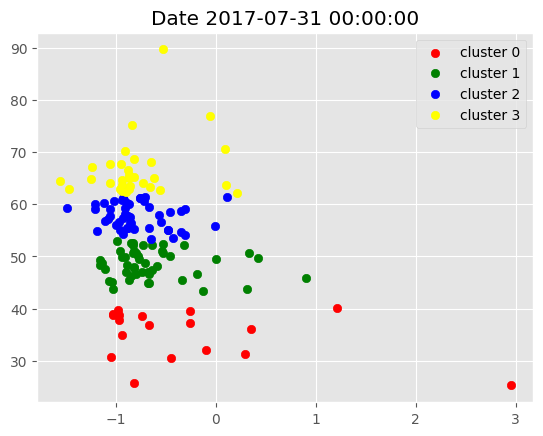

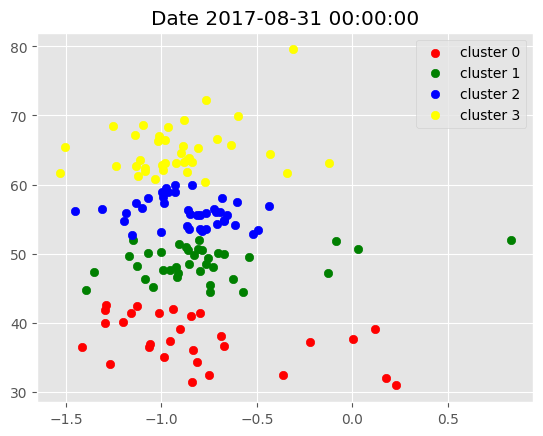

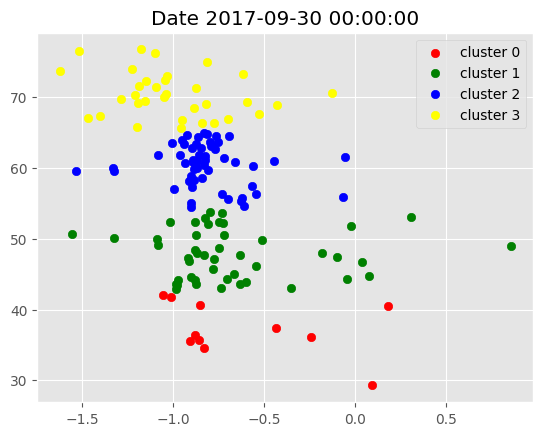

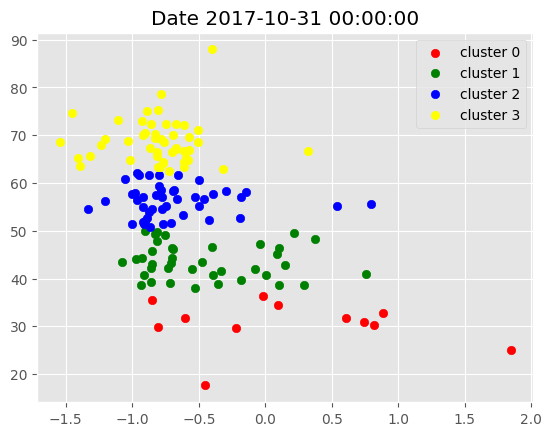

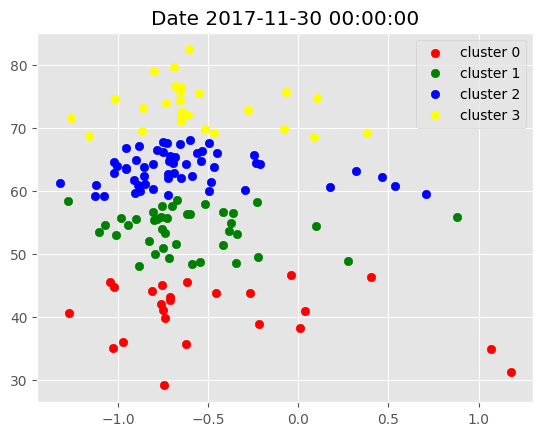

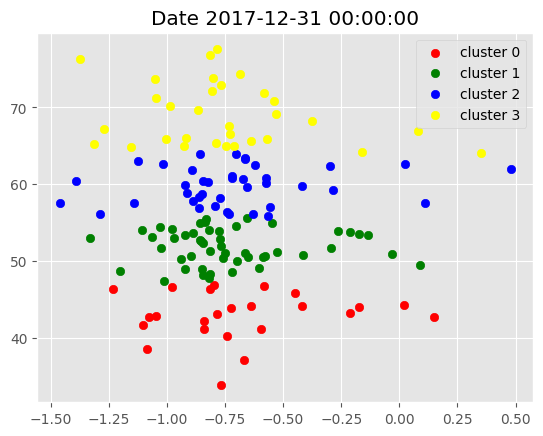

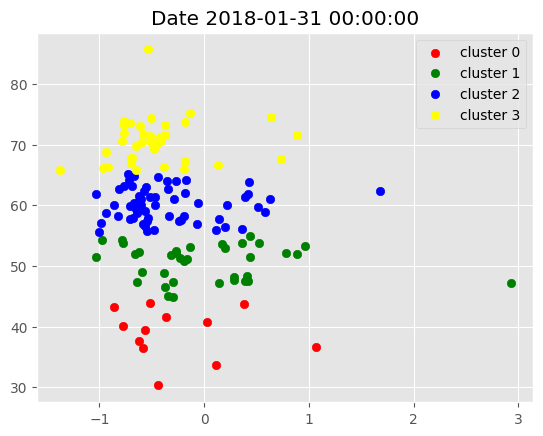

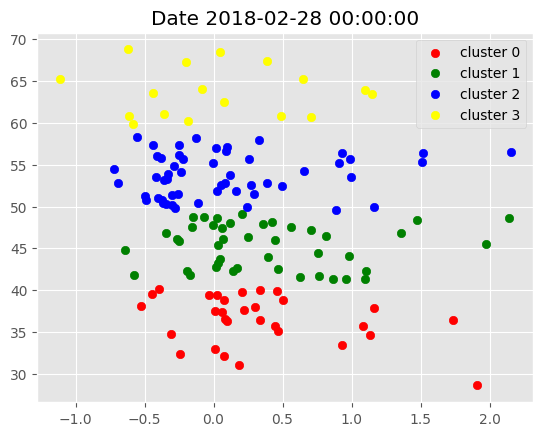

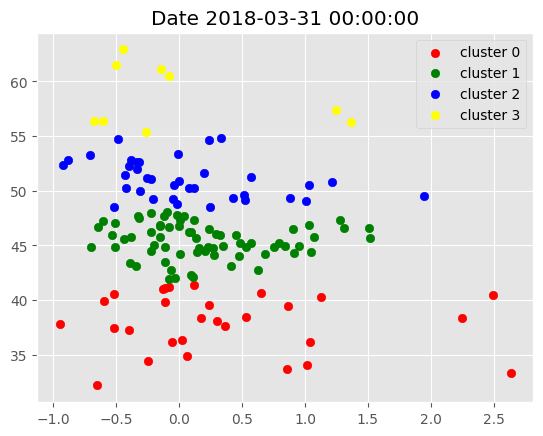

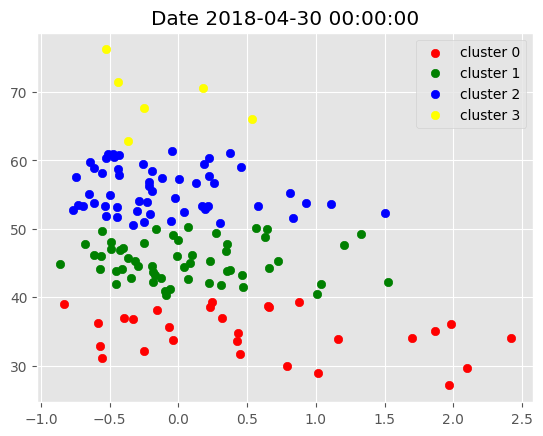

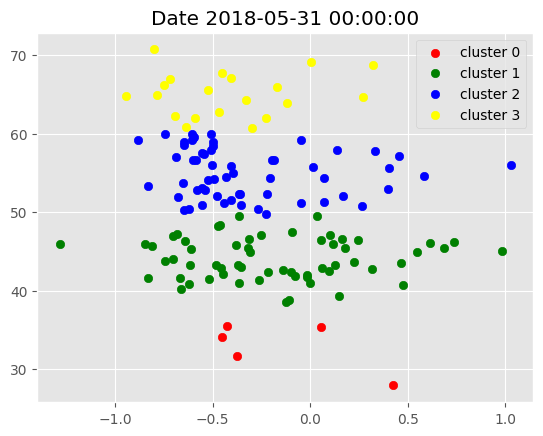

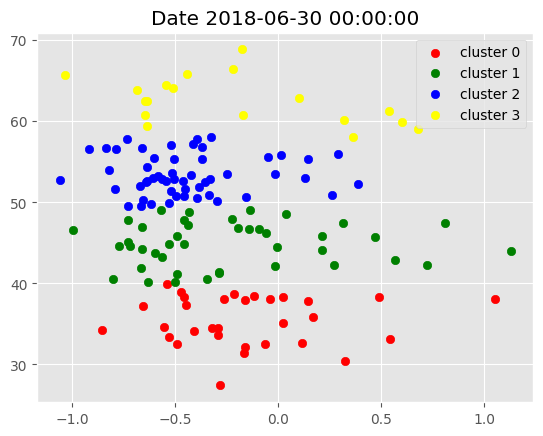

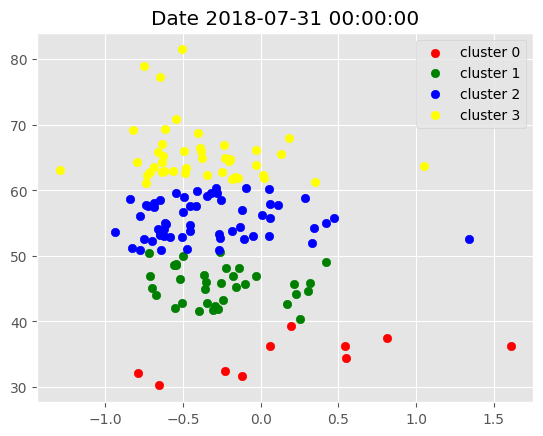

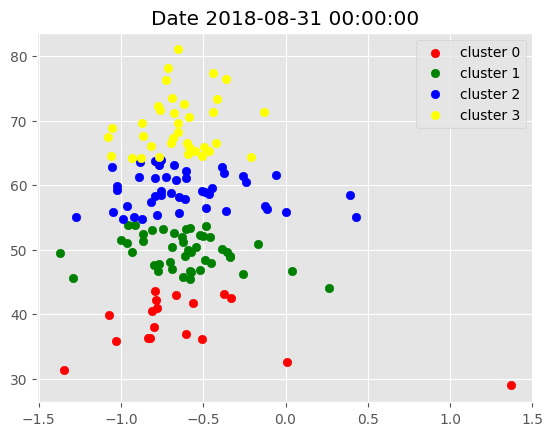

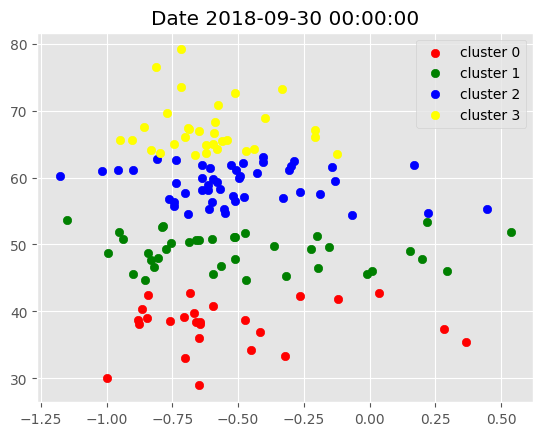

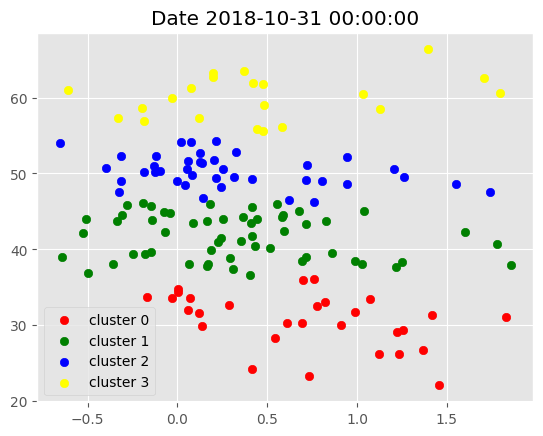

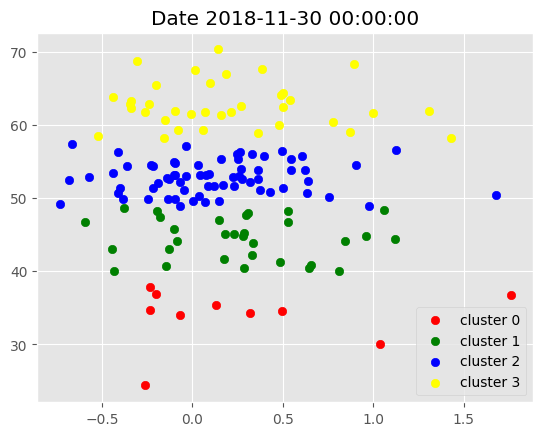

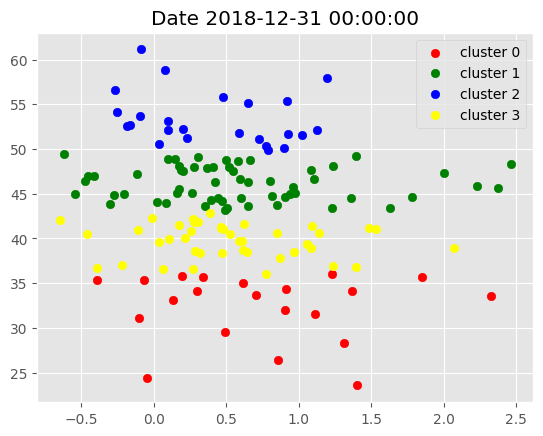

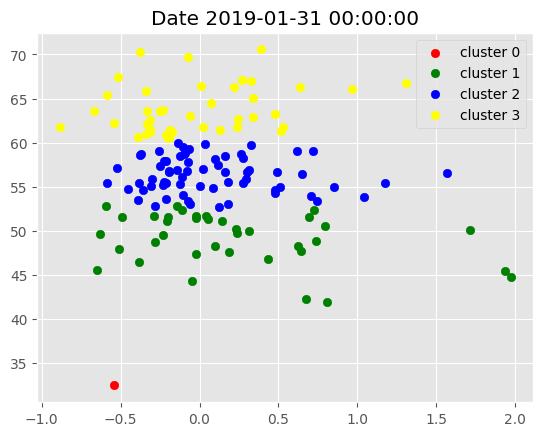

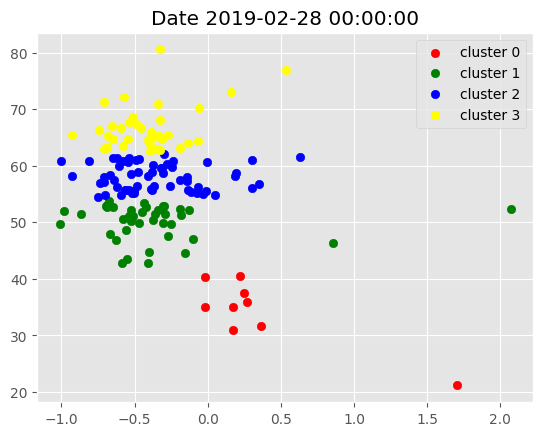

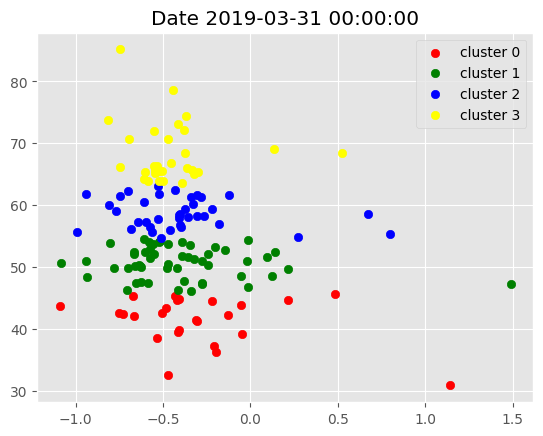

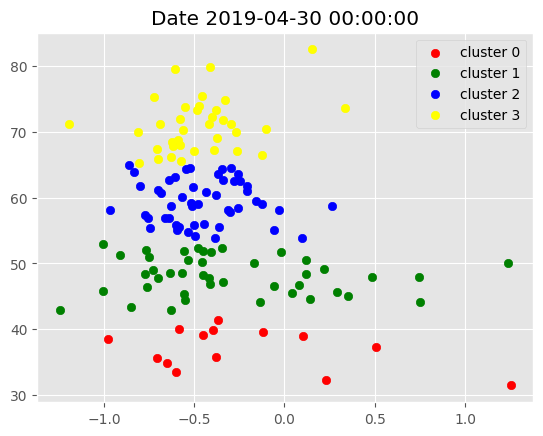

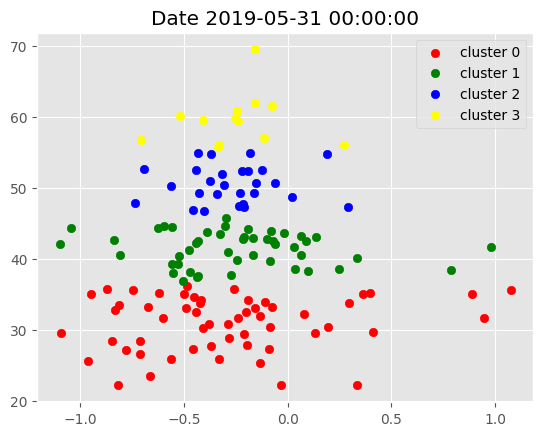

In [12]:
itr = 0
for i in data.index.get_level_values('date').unique().tolist():
    if itr > 50:
        break;
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)
    itr = itr + 1

In [13]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index + pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2015-04-01': ['ACN',
  'BSX',
  'CHTR',
  'COST',
  'DG',
  'ELV',
  'EXPE',
  'HAL',
  'NKE',
  'NXPI',
  'PFE',
  'TGT',
  'UNH',
  'VLO'],
 '2015-05-01': ['ABBV',
  'AMZN',
  'BK',
  'BKNG',
  'CAT',
  'CRM',
  'DD',
  'DVN',
  'EOG',
  'FCX',
  'HAL',
  'IBM',
  'LYB',
  'MDLZ',
  'MRO',
  'MSFT',
  'NFLX',
  'SLB',
  'T',
  'TSLA',
  'VZ',
  'YUM'],
 '2015-06-01': ['ABBV',
  'DE',
  'EBAY',
  'ELV',
  'GILD',
  'GS',
  'INTC',
  'LLY',
  'MDLZ',
  'NFLX',
  'NXPI',
  'REGN',
  'SBUX',
  'TSLA'],
 '2015-07-01': ['AIG',
  'BAX',
  'CMCSA',
  'COF',
  'CVS',
  'DE',
  'DG',
  'DIS',
  'EXPE',
  'GILD',
  'LLY',
  'MDLZ',
  'MET',
  'META',
  'NFLX',
  'NKE',
  'SBUX',
  'T',
  'TSLA',
  'UNH',
  'VLO',
  'WMB'],
 '2015-08-01': ['ACN',
  'AMGN',
  'AMZN',
  'BAX',
  'CMG',
  'CVS',
  'DIS',
  'EXPE',
  'GOOG',
  'GOOGL',
  'LMT',
  'MDLZ',
  'MO',
  'NFLX',
  'NKE',
  'PFE',
  'SBUX',
  'V',
  'WBA'],
 '2015-09-01': ['BKNG'],
 '2015-10-01': ['ADBE',
  'COST',
  'GE',
  'INTC',
  'KO

In [14]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0): # supply full year of prices
    returns = expected_returns.mean_historical_return(prices=prices, frequency=252) # expected returns
    cov = risk_models.sample_cov(prices=prices, frequency=252) # covariance

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound,.1), # diversify by capping the weights
                           solver='SCS')
    weights = ef.max_sharpe()

    return ef.clean_weights()


In [15]:
# get the past year of stock info
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                    end=data.index.get_level_values('date').unique()[-1])
new_df

[******************    37%%                      ]  64 of 175 completed

$CI: possibly delisted; No price data found  (1d 2014-03-31 00:00:00 -> 2024-01-31 00:00:00)


[*********************100%%**********************]  175 of 175 completed

1 Failed download:
['CI']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2014-03-31 00:00:00 -> 2024-01-31 00:00:00)')


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV        ABNB         ABT   
Date                                                                    
2014-03-31  34.504341   16.861732   33.445553         NaN   31.452080   
2014-04-01  35.767616   17.015976   33.901035         NaN   31.419407   
2014-04-02  35.550781   17.044249   34.707897         NaN   31.509241   
2014-04-03  35.201969   16.926125   34.812000         NaN   31.566429   
2014-04-04  34.466637   16.707167   33.966118         NaN   31.550079   
...               ...         ...         ...         ...         ...   
2024-01-24  13.930000  193.988998  161.219528  141.190002  109.641670   
2024-01-25  15.360000  193.659882  162.112915  142.110001  111.304558   
2024-01-26  15.130000  191.914474  161.396240  149.619995  110.869049   
2024-01-29  14.940000  191.226288  160.915192  152.699997  112.294373   
2024-01-30  14.530000  187.545975  161.906738  149.440002  112.324074   

Price                                                                  ...  \
Ticker             ACN        ADBE         ADP        ADSK        AIG  ...   
Date                                                                   ...   
2014-03-31   66.152550   65.739998   54.176636   49.180000  39.388756  ...   
2014-04-01   66.003174   65.930000   54.344917   50.070000  39.357254  ...   
2014-04-02   66.376617   65.480003   54.464146   49.580002  39.821945  ...   
2014-04-03   65.845497   62.450001   54.253750   48.310001  40.034611  ...   
2014-04-04   64.841446   61.320000   53.166859   47.320000  39.814075  ...   
...                ...         ...         ...         ...        ...  ...   
2024-01-24  365.872559  606.479980  235.711838  252.660004  68.460419  ...   
2024-01-25  368.887634  622.580017  234.011520  251.750000  68.282242  ...   
2024-01-26  368.024780  613.929993  233.398621  253.070007  68.826675  ...   
2024-01-29  370.286072  630.229980  234.990189  257.230011  68.668289  ...   
2024-01-30  368.252869  627.960022  235.860107  256.470001  69.668068  ...   

Price         Volume                                                   \
Ticker          VTRS        VZ       WBA       WDC       WFC      WMB   
Date                                                                    
2014-03-31   7880700  20744100   4845200   2582200  17901800  6639700   
2014-04-01   6001900  19712800   4662400   2137800  16397000  6724300   
2014-04-02   5445500  25156000   3936100   1746700  13036800  5230000   
2014-04-03   6225800  19320900   5291400   1619600   9598900  3589000   
2014-04-04  17748200  20772000   5943200   2527700  18702400  4459300   
...              ...       ...       ...       ...       ...      ...   
2024-01-24   6947500  27910400   9246400   9723800  17776000  5476000   
2024-01-25   6124800  24613200  14707700  23848700  17979600  6070400   
2024-01-26   7106300  20367200  10150200  19645800  19211100  6289600   
2024-01-29   6216500  23905700  12197400   9380300  16725200  6037700   
2024-01-30   5619000  20044600  11689100   9717100  14736800  4792400   

Price                                             
Ticker           WMT     WYNN       XOM      YUM  
Date                                              
2014-03-31  14086800  1680600  12375200  4592526  
2014-04-01  17310000  1691400   9475300  3799517  
2014-04-02  18234300   988700   9551000  5344778  
2014-04-03  18121500  1223100  10113000  3832205  
2014-04-04  20280600  1785500  12496100  3627867  
...              ...      ...       ...      ...  
2024-01-24  22932900  2318700  17330600  1790100  
2024-01-25  16369500  2568600  22089500  1871700  
2024-01-26  15746400  1465200  20817200  1157000  
2024-01-29  18240300  1261800  18317500  1482100  
2024-01-30  15270000  1388400  19610900  1421500  

[2476 rows x 1050 columns]

In [35]:
returns_df = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:    
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]
    
        # calculate weights using past year info
        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                    lower_bound=round(1/(len(optimization_df.columns)*2),3))
            weights = pd.DataFrame(weights, index=pd.Series(0))
            success = True
        except:
           print(f'Max Sharpe opt failed for {start_date}, continuing with Equal-Weights')

        if not success:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                  index=optimization_df.columns.tolist(),
                                  columns=pd.Series(0)).T
        temp_df = returns_df[start_date:end_date]
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                    .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                                                                                left_index=True,
                                                                                right_index=True)\
                    .reset_index().set_index(['Date', 'index']).unstack().stack()
        temp_df.index.names = ['date', 'ticker']
        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('strategy return')
        
        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe opt failed for 2015-09-01, continuing with Equal-Weights
Max Sharpe opt failed for 2016-01-01, continuing with Equal-Weights
Max Sharpe opt failed for 2016-03-01, continuing with Equal-Weights
Max Sharpe opt failed for 2017-09-01, continuing with Equal-Weights
Max Sharpe opt failed for 2017-11-01, continuing with Equal-Weights
Max Sharpe opt failed for 2017-12-01, continuing with Equal-Weights
Max Sharpe opt failed for 2018-04-01, continuing with Equal-Weights
Max Sharpe opt failed for 2018-05-01, continuing with Equal-Weights
Max Sharpe opt failed for 2018-10-01, continuing with Equal-Weights
Max Sharpe opt failed for 2018-11-01, continuing with Equal-Weights
Max Sharpe opt failed for 2018-12-01, continuing with Equal-Weights
Max Sharpe opt failed for 2019-01-01, continuing with Equal-Weights
Max Sharpe opt failed for 2019-11-01, continuing with Equal-Weights
Max Sharpe opt failed for 2019-12-01, continuing with Equal-Weights
Max Sharpe opt failed for 2020-03-01, continuing

,strategy return
date,
2015-04-01,-0.005455
2015-04-02,0.000900
2015-04-06,0.007428
2015-04-07,-0.006484
2015-04-08,0.007287
...,...
2024-01-24,-0.000183
2024-01-25,0.007931
2024-01-26,-0.002047


In [39]:
spy = yf.download(tickers='SPY',
                  start='2015-04-01',
                  end=dt.date.today())
spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close': 'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,strategy return,SPY Buy&Hold
2015-04-02,0.000900,0.003591
2015-04-06,0.007428,0.006710
2015-04-07,-0.006484,-0.002650
2015-04-08,0.007287,0.003371
2015-04-09,-0.000422,0.004414
...,...,...
2024-01-24,-0.000183,0.001093
2024-01-25,0.007931,0.005424
2024-01-26,-0.002047,-0.001271
2024-01-29,0.011814,0.007888


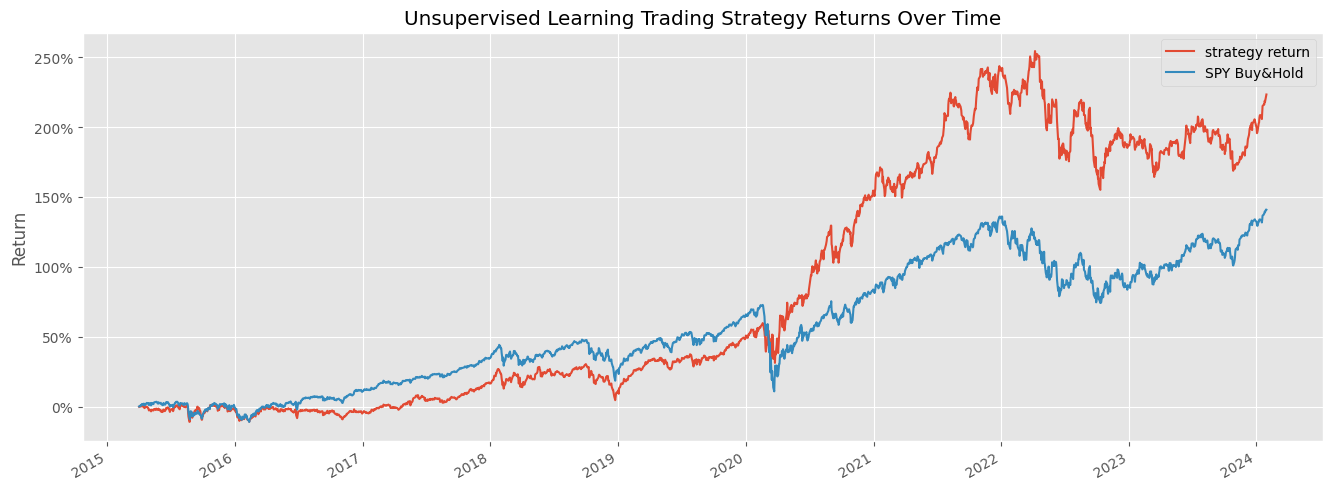

In [43]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2024-01-30'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()